# Text Analysis
The purpose of this notebook is to analyse the text of the social media posts.

## Structure
1. ...
    1. ...

## Summarized Results
- ...

In [2]:
from scripts.preprocess_data import *
# Load, clean and normalize the df
df = load_data()
df = clean_data(df)
df = normalize_data(df)

### Post Length

Overview with average

Average text length: 177.81356390549388
Median text length: 175.0


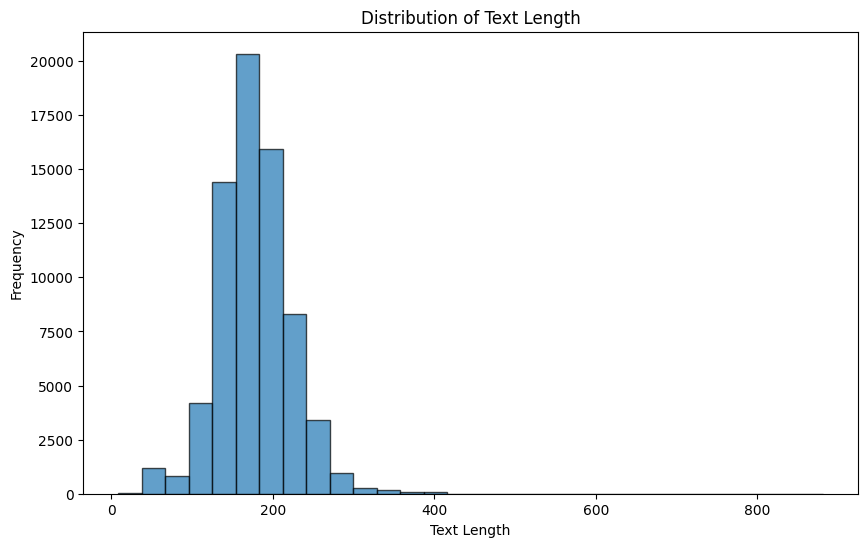

In [3]:
import matplotlib.pyplot as plt

# Compute the length of each text
df['text_length'] = df['text'].apply(len)

# Calculate average and median text length
average_length = df['text_length'].mean()
median_length = df['text_length'].median()

print(f"Average text length: {average_length}")
print(f"Median text length: {median_length}")

# Plot the distribution of text length
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Outliers (long posts only)

Number of posts with text_length > 400: 38


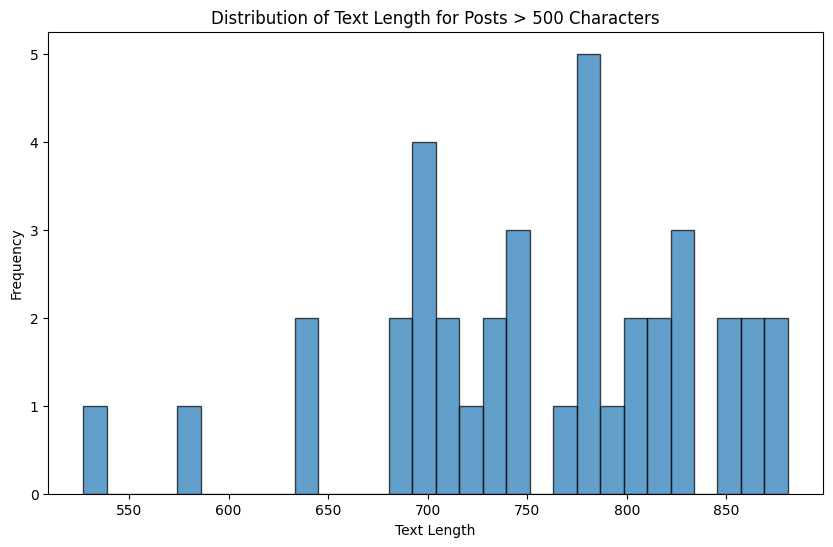

In [4]:
# Filter posts with text_length > 500
long_posts = df[df['text_length'] > 500]
# X (formerly Twitter) has a character limit of 280 per post

# Count the number of such posts
num_long_posts = len(long_posts)

# Print the count
print(f"Number of posts with text_length > 400: {num_long_posts}")

# Generate a distribution of these posts
plt.figure(figsize=(10, 6))
plt.hist(long_posts['text_length'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Text Length for Posts > 500 Characters')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [5]:
print("\nPosts with text length greater than 400:")
print(long_posts[['user_id', 'text', 'text_length']])


Posts with text length greater than 400:
          user_id                                               text  \
9516   1064632123  loranhayden friendsoscience ejwwest danielkuhn...   
17438  1005036246  climateskeptic4 gordondhg bubbasranch ejwwest ...   
17716  1005036246  climateskeptic4 gordondhg bubbasranch ejwwest ...   
17922  1005036246  bbolshevik100 climateskeptic4 gordondhg bubbas...   
18036  1005036246  climateskeptic4 gordondhg bubbasranch ejwwest ...   
18121  1005036246  climateskeptic4 gordondhg bubbasranch ejwwest ...   
18647  1005036246  climateskeptic4 gordondhg bubbasranch ejwwest ...   
21256  1064632123  priscian ingersolrobert guygadboisguyg1 canadi...   
24827  1083611406  new course developed by jonesshirley in collab...   
26220  1005036246  bbolshevik100 climateskeptic4 gordondhg bubbas...   
26410  1005036246  bbolshevik100 climateskeptic4 gordondhg bubbas...   
26500  1005036246  bbolshevik100 climateskeptic4 gordondhg bubbas...   
26681  1005036246  wil

Exact duplicates

In [6]:
# Identify duplicate posts among long posts
duplicates = long_posts[long_posts.duplicated(subset='text', keep=False)]

# Count the number of duplicates
num_duplicates = len(duplicates)

# Group duplicates by user_id and count the number of duplicate posts per user
duplicates_by_user = duplicates.groupby('user_id').size().sort_values(ascending=False)

# Display duplicate posts themselves
duplicate_posts = duplicates[['user_id', 'text_length', 'text']].drop_duplicates(subset='text')

# Output the results
print(f"Number of duplicate posts: {num_duplicates}\n")
print("Users with the number of duplicate posts:")
print(duplicates_by_user)

print("\nDuplicate posts:")
print(duplicate_posts)

Number of duplicate posts: 0

Users with the number of duplicate posts:
Series([], dtype: int64)

Duplicate posts:
Empty DataFrame
Columns: [user_id, text_length, text]
Index: []


- There are no exact duplicates in the outlier long posts.

Near duplicates (threshold of $90\%$)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Filter posts with text_length > 400
long_posts = df[df['text_length'] > 400].copy()

# Reset the index for easier handling
long_posts.reset_index(inplace=True)

# Step 1: Calculate TF-IDF vectors for the texts
vectorizer = TfidfVectorizer().fit_transform(long_posts['text'])
similarity_matrix = cosine_similarity(vectorizer)

# Step 2: Identify near duplicates (similarity > 0.9 but not identical)
threshold = 0.9
duplicates = []

for i in range(similarity_matrix.shape[0]):
    duplicates.extend(
        (long_posts.loc[i, 'user_id'], long_posts.loc[j, 'user_id'], i, j)
        for j in range(i + 1, similarity_matrix.shape[0])
        if similarity_matrix[i, j] > threshold
    )
# Convert to DataFrame for analysis
duplicate_posts = pd.DataFrame(duplicates, columns=['user_id_1', 'user_id_2', 'post_index_1', 'post_index_2'])

# Step 3: Count duplicates per user
user_duplicate_counts = (
    duplicate_posts[['user_id_1', 'user_id_2']]
    .stack()
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'user_id', 0: 'duplicate_count'})
)

# Step 4: Extract duplicate post details
duplicate_details = []

for _, row in duplicate_posts.iterrows():
    post_1 = long_posts.loc[row['post_index_1'], 'text']
    post_2 = long_posts.loc[row['post_index_2'], 'text']
    duplicate_details.append({
        'user_id_1': row['user_id_1'],
        'user_id_2': row['user_id_2'],
        'post_1': post_1,
        'post_2': post_2
    })

# Display results
print(f"Number of duplicate pairs: {len(duplicates)}")
print("\nUsers with duplicate post counts:")
print(user_duplicate_counts)

# Optional: View duplicate posts
print("\nDuplicate post details:")
print(pd.DataFrame(duplicate_details).head(10))

Number of duplicate pairs: 28

Users with duplicate post counts:
       user_id  count
0   1018902097      4
1   1012123899      4
2   1014085813      4
3   1062877905      3
4   1034942858      3
5   1035911941      3
6   1037634134      3
7   1062181611      2
8   1075477544      2
9   1026852577      2
10  1087964122      2
11  1037338421      2
12  1004202192      2
13  1010691912      2
14  1024257879      2
15  1061862662      2
16  1001624675      2
17  1012982494      2
18  1071022623      2
19  1036392663      2
20  1046526890      2
21  1047275890      1
22  1076358587      1
23  1033408696      1
24  1032954778      1

Duplicate post details:
    user_id_1   user_id_2                                             post_1  \
0  1018902097  1014085813  david45 bmoss santiagotina erin86 qherrera har...   
1  1018902097  1012123899  david45 bmoss santiagotina erin86 qherrera har...   
2  1018902097  1012123899  david45 bmoss erin86 qherrera jasmine08 aaron9...   
3  1018902097  101

In [17]:
df_duplicate_details = pd.DataFrame(duplicate_details)
df_duplicate_details.columns

Index(['user_id_1', 'user_id_2', 'post_1', 'post_2'], dtype='object')

In [25]:
df_duplicate_details.loc[8]['post_1']

'data science and analytics are vital for solving problems and improving lives with skills in data visualization machine learning and statistics the average salary for data scientists is 117000 per year datascience analytics\n\na software engineering manager leads and supports other engineers contributing to the global business software and services market the average salary for this role is 137482 per year softwareengineering manager'

In [27]:
df_duplicate_details.loc[8]['post_1'] == df_duplicate_details.loc[8]['post_2']

True

In [30]:
df_duplicate_details.loc[8]['user_id_1'], df_duplicate_details.loc[8]['user_id_2']

(1075477544, 1046526890)

In [37]:
df[df['user_id'] == 1075477544]

,timestamp,text,text_id,user,user_id,text_length,cleaned_text
11569,2024-10-31 03:07:17,data science and analytics are vital for solvi...,2072110448,wardangelica,1075477544,435,data science analytics vital solving problems ...
39855,2024-10-31 10:27:22,the software engineering manager oversees proj...,2071389760,wardangelica,1075477544,421,software engineering manager oversees projects...


In [38]:
df[df['user_id'] == 1046526890]

,timestamp,text,text_id,user,user_id,text_length,cleaned_text
70120,2024-10-31 23:56:27,data science and analytics are vital for solvi...,2077495818,gmorris,1046526890,435,data science analytics vital solving problems ...
70135,2024-10-31 23:57:03,the software engineering manager oversees proj...,2014302771,gmorris,1046526890,421,software engineering manager oversees projects...


- Two accounts with different names have the same post. gmorris is likely a bot which runs close before midnight and posts the same content as wardangelica

In [39]:
import pandas as pd
from collections import defaultdict

# Step 1: Group posts by their cleaned_text
df_sorted = df.sort_values(by='cleaned_text')  # Sorting by cleaned_text
grouped = defaultdict(list)

# Store user_ids for each unique cleaned_text
for _, row in df_sorted.iterrows():
    grouped[row['cleaned_text']].append(row['user_id'])

# Step 2: Find accounts with duplicate posts
duplicate_accounts = []

duplicate_accounts.extend(
    (text, set(user_ids))
    for text, user_ids in grouped.items()
    if len(set(user_ids)) > 1
)
# Step 3: Output results
print(f"Number of duplicate texts shared by multiple accounts: {len(duplicate_accounts)}")

# Show examples of duplicates
for i, (text, users) in enumerate(duplicate_accounts[:10], 1):  # Limit to 10 examples
    print(f"Example {i}:")
    print(f"Text: {text}")
    print(f"Users: {users}\n")

Number of duplicate texts shared by multiple accounts: 15786
Example 1:
Text: 1 day left teisslondon2022 get ready dynamic dialogue resilience response recovery cybersecurity dont miss opportunity connect senior decisionmakers advance knowledge countdown cybersecuritysummit
Users: {1012072114, 1071930970}

Example 2:
Text: 1 misuse classified information poses serious threat democracy former defense secretary gates criticizes vice president joe bidens track record national security classifiedinfo nationalsecurity democracy
Users: {1031039409, 1075271908}

Example 3:
Text: 1 month team joins kevinrodriguez conference entrepreneurs experience 2022 swing chat dedicated office friendly account management team learn support business needs business conference support
Users: {1042138482, 1078442583}

Example 4:
Text: 1 week left big event want join us tickets free register secure spot dont miss businessshow networking
Users: {1013092794, 1083504501}

Example 5:
Text: 1 week left cyber securit

In [59]:
# Specify the index of the duplicate_accounts you want to analyze
index = 0  # Replace with the desired index

# Get the shared text and user IDs at the specified index
if 0 <= index < len(duplicate_accounts):
    shared_text, user_ids = duplicate_accounts[index]  # Extract data
    user_ids = list(user_ids)  # Convert the set of user_ids to a list

    # Display the user IDs
    # print(f"Shared text: {shared_text}")
    print(f"User IDs sharing this text: {user_ids}")
else:
    print("Invalid index. Please choose an index within the range of duplicate_accounts.")


User IDs sharing this text: [1012072114, 1071930970]


In [60]:
df[df['user_id'] == 1012072114]

,timestamp,text,text_id,user,user_id,text_length,cleaned_text
53371,2024-10-31 15:52:51,1 day left until teisslondon2022 get ready for...,2083440343,jasminrojas,1012072114,254,1 day left teisslondon2022 get ready dynamic d...


In [62]:
df[df['user_id'] == 1071930970]

,timestamp,text,text_id,user,user_id,text_length,cleaned_text
28934,2024-10-31 07:18:47,1 day left until teisslondon2022 get ready for...,2059372698,kevinhayes,1071930970,254,1 day left teisslondon2022 get ready dynamic d...


Q1 and Q3: First and third quartiles are calculated to measure the spread of the data. $\newline$
IQR: The range between Q1 and Q3, which captures the middle $50\%$ of the data.$\newline$
Bounds: Text lengths outside `Q1 - 1.5 * IQR and Q3 + 1.5 * IQR` are considered outliers.$\newline$
Result: The DataFrame outliers contains all rows identified as potential outliers based on text length.

In [8]:
# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = df['text_length'].quantile(0.25)
Q3 = df['text_length'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify potential outliers
outliers = df[(df['text_length'] < lower_bound) | (df['text_length'] > upper_bound)]

print(f"Number of outliers: {len(outliers)}")
print("Outlier samples:")
print(outliers[['text', 'text_length']])


Number of outliers: 2429
Outlier samples:
                                                    text  text_length
18     petersjoseph jonathan79 donaldaguirre cjones s...          400
48     wwf no mercy usa1 variant nintendo 64 n64 cart...           63
152    jacquelinestewart teresajackson collinslisa as...          324
160    jonathan79 robert01 kimberlyrichards maloneama...          301
247    the ongoing influence of owners and the media ...          291
...                                                  ...          ...
70093  saint paul island oct 31 climate high 47 low 4...           65
70094  kodiak oct 31 climate high 50 low 41 precip 01...           54
70120  data science and analytics are vital for solvi...          435
70135  the software engineering manager oversees proj...          421
70221  improving school environments can lead to bett...          289

[2429 rows x 2 columns]


- The histogram shows that the majority of texts have lengths clustered around 175 characters, with a gradual decline in frequency for both shorter and longer texts, indicating a right-skewed distribution with occasional outliers.

### Post Frequency

In [9]:
# Extract unique days from the 'timestamp' column
unique_days = df['timestamp'].dt.date.unique()

# Check if all posts are from the same day
if len(unique_days) == 1:
    print(f"All posts are from the same day: {unique_days[0]}")
else:
    print("The posts span multiple days. Here are the unique days:")
    print(unique_days)


All posts are from the same day: 2024-10-31


- The data basis is limited to one day (31st October 2024).

In [10]:
# Calculate the number of unique users
unique_users = df['user_id'].nunique()
print(f"Number of unique users: {unique_users}")

# Ensure 'timestamp' is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate overall post count
total_posts = df.shape[0]
print(f"Total number of posts: {total_posts}")

# Calculate the average tweets per user
average_tweets_per_user = total_posts / unique_users
print(f"Average tweets per user: {average_tweets_per_user:.2f}")

Number of unique users: 46755
Total number of posts: 70260
Average tweets per user: 1.50


- With an average of **1.50 posts per user**, most users are likely **casual participants**, indicating moderate engagement, while a small number of highly active users (or bots) may be driving the overall post count.

No temporal analysis over multiple days, months or years can be performed because all posts are from 31st October 2024.

### Topic Modelling

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

# Define a function to preprocess text
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

# Preprocess the text column
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Convert the text df into a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['cleaned_text'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Specify number of topics (n_components)
lda.fit(doc_term_matrix)

# Get the top words for each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[-num_top_words:]]))

# Display topics
num_top_words = 10  # Number of top words to display per topic
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, num_top_words)

[nltk_data] Downloading package stopwords to /Users/leori/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 0:
dont, miss, low, new, high, join, climate, check, science, business
Topic 1:
support, army, love, voting, social, btsbbmas, artist, lets, vote, yhawkins
Topic 2:
people, new, real, political, energy, climate, time, change, like, politics
Topic 3:
success, looking, dont, need, politics, help, like, hey, check, business
Topic 4:
check, time, important, support, crucial, care, lets, healthcare, mental, health


define output for visualizations - databasis is in the name -> define in the beginning
run in python with databasis as a parameter

In [12]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

# Prepare df for LDA (as a bag of words)
texts = df['text'].apply(lambda x: x.split()).tolist()  # Split text into tokens
dictionary = Dictionary(texts)  # Create a Gensim dictionary
corpus = [dictionary.doc2bow(text) for text in texts]  # Create a bag-of-words corpus

# Train LDA model using Gensim
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42, passes=10)

# Visualize topics using pyLDAvis
lda_visualization = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(lda_visualization)  # For Jupyter Notebooks

KeyboardInterrupt: 

### Named Entity Recognition

In [7]:
import spacy
from collections import Counter

# Load spaCy's English language model
nlp = spacy.load("en_core_web_sm")

# Define a function to perform NER on text
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply NER to the 'text' column
df['entities'] = df['text'].apply(extract_entities)

# Extract and count entities by type
all_entities = sum(df['entities'], [])  # Flatten the list of entities
entity_counter = Counter([entity[1] for entity in all_entities])
print("\nEntity Type Counts:")
print(entity_counter)

# Extract most common entities
most_common_entities = Counter(list(all_entities)).most_common(10)
print("\nMost Common Entities:")
print(most_common_entities)


OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [ ]:
def filter_entities_by_type(entities, entity_type):
    return [entity[0] for entity in entities if entity[1] == entity_type]

df['people'] = df['entities'].apply(lambda ents: filter_entities_by_type(ents, 'PERSON'))
df['organizations'] = df['entities'].apply(lambda ents: filter_entities_by_type(ents, 'ORG'))
df['locations'] = df['entities'].apply(lambda ents: filter_entities_by_type(ents, 'GPE'))

### Sentiment Analysis

sentiment
positive    47164
negative    14464
neutral      8632
Name: count, dtype: int64


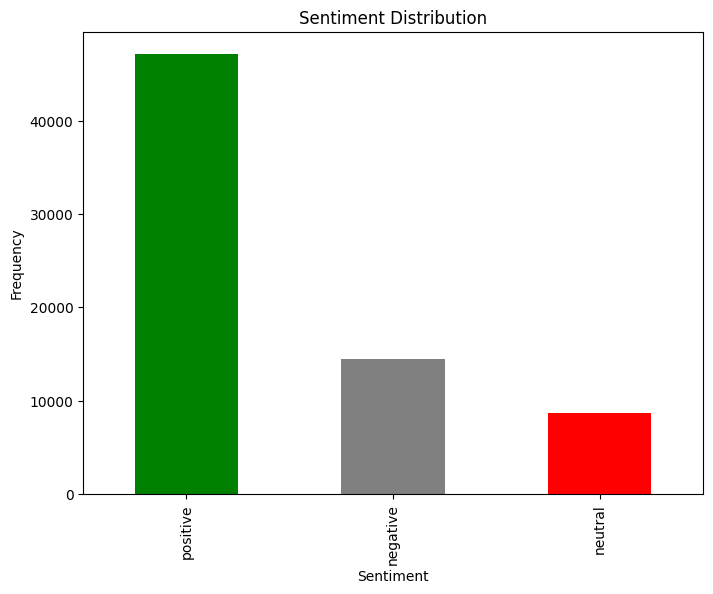

In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment
def analyze_sentiment(text):
    sentiment_scores = analyzer.polarity_scores(text)
    # Determine sentiment as positive, neutral, or negative
    if sentiment_scores['compound'] >= 0.05:
        return 'positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to the 'text' column
df['sentiment'] = df['text'].apply(analyze_sentiment)

# Output the distribution of sentiments
print(df['sentiment'].value_counts())

# Visualize sentiment distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
df['sentiment'].value_counts().plot(kind='bar', color=['green', 'gray', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

- The sentiment analysis shows that the majority of tweets are positive ($47,164$), followed by negative ($14,464$) and neutral ($8,632$), suggesting that the Halloween-related content predominantly evokes positive emotions due to celebration, community engagement (costume or decoration celebration), humor, nostalgia and tradition. Negative emotions may be caused by fear and disturbance, exclusion, dislike, stress, overwhelm or FOMO. 


In [42]:
from textblob import TextBlob

def analyze_sentiment_textblob(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['text'].apply(analyze_sentiment_textblob)
